# Project -1 -> Music Genre Classification

# IMPORTING LIBRARIES

In [182]:
import librosa
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random
import IPython
import librosa.display as lplt
seed = 12
np.random.seed(seed)
from sklearn.preprocessing import StandardScaler

# LOADING DATASET

In [183]:
df = pd.read_csv(r"C:\Users\nisha\Desktop\archive\Data\features_3_sec.csv")
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


# ABOUT THE DATA

In [184]:
print("Dataset has",df.shape)
print("Count of Positive and Negative samples")
df.label.value_counts().reset_index()

Dataset has (9990, 60)
Count of Positive and Negative samples


,label,count
0,blues,1000
1,jazz,1000
2,metal,1000
3,pop,1000
4,reggae,1000
5,disco,999
6,classical,998
7,hiphop,998
8,rock,998
9,country,997


# DATA VISUALIZATION

In [185]:
# Define the path to the 'genres_original' directory
base_dir = r"C:\Users\nisha\Desktop\archive\Data\genres_original"

# List the subdirectories (genres) within 'genres_original'
genres = os.listdir(base_dir)

# Choose a random genre
random_genre = random.choice(genres)

# Get the path to the chosen genre directory
genre_dir = os.path.join(base_dir, random_genre)

# List all audio files in the chosen genre directory
audio_files = [os.path.join(genre_dir, filename) for filename in os.listdir(genre_dir) if filename.endswith(".wav")]

# Select a random audio file from the list
audio_file_path = random.choice(audio_files)

# Load the selected audio file
audio_data, sample_rate = librosa.load(audio_file_path)
audio_data, _ = librosa.effects.trim(audio_data)


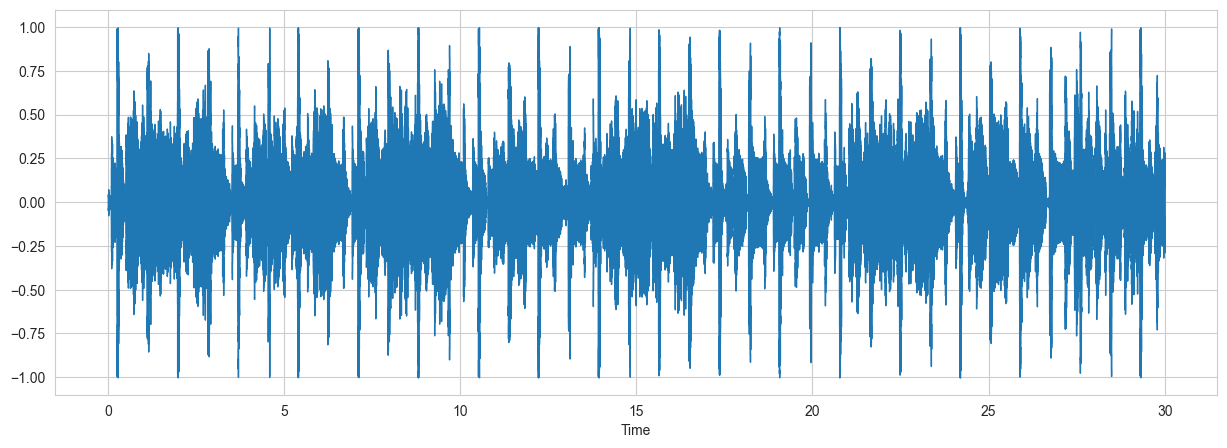

In [186]:
# Play audio
IPython.display.Audio(audio_data, rate=sample_rate)

# Plot waveform
plt.figure(figsize=(15, 5))
librosa.display.waveshow(audio_data)
plt.show()

In [187]:
# Define STFT parameters
n_fft = 2048
hop_length = 512

# Compute STFT
stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
stft_db = librosa.amplitude_to_db(stft, ref=np.max)

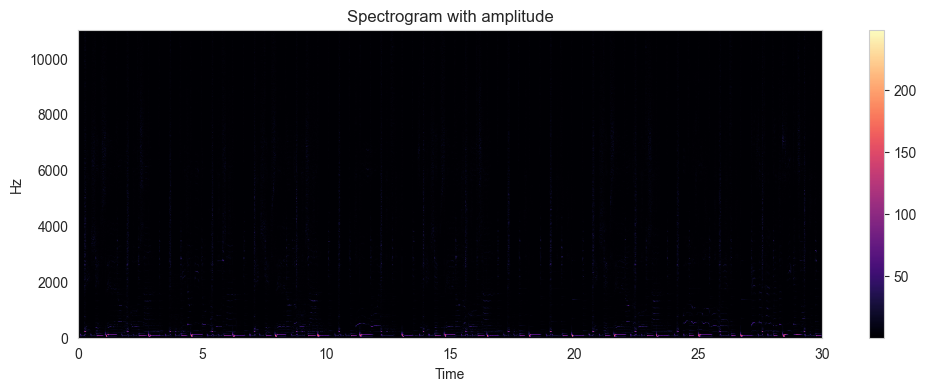

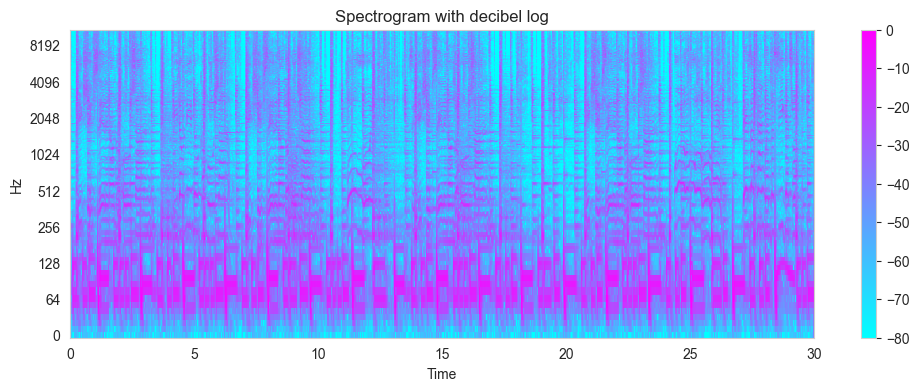

In [188]:
# Plot spectrogram
plt.figure(figsize=(12, 4))
librosa.display.specshow(stft, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram with amplitude")
plt.show()

# Plot spectrogram with decibel scale
plt.figure(figsize=(12, 4))
librosa.display.specshow(stft_db, sr=sample_rate, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Spectrogram with decibel log")
plt.show()

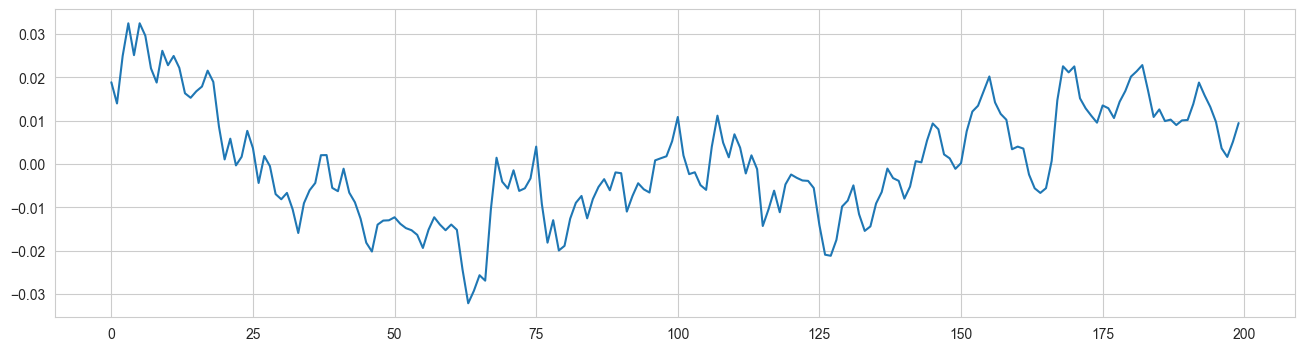

In [189]:
# Plot zoomed audio wave
start = 1000
end = 1200
plt.figure(figsize=(16, 4))
plt.plot(audio_data[start:end])
plt.show()

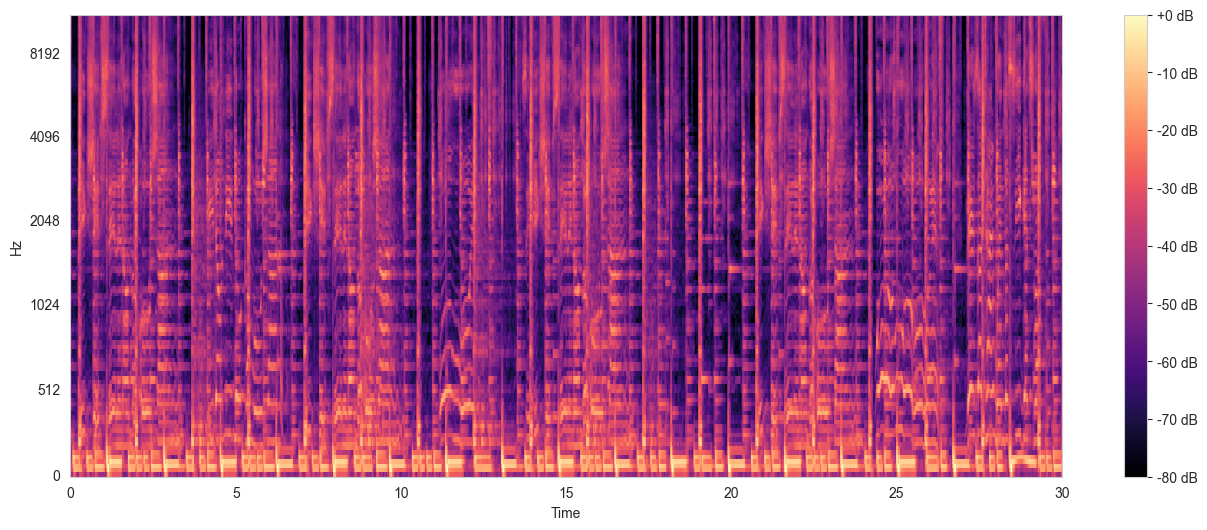

In [190]:
# Calculate the Mel spectrogram
mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Plot the Mel spectrogram
plt.figure(figsize=(16, 6))
librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sample_rate, hop_length=512)
plt.colorbar(format='%+2.0f dB')
plt.show()

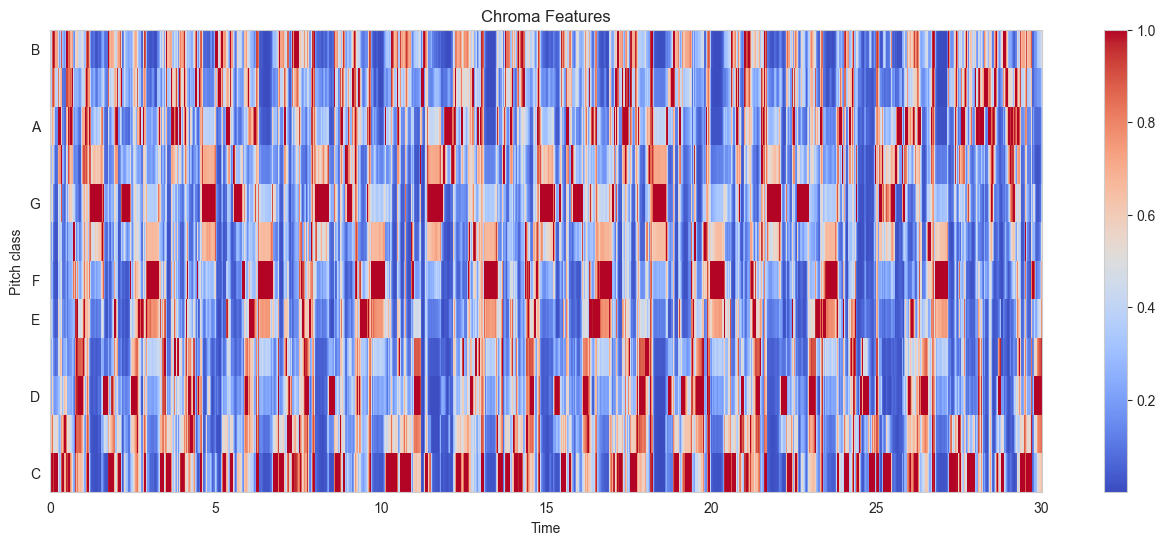

In [191]:
# Calculate Chroma features
chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)
plt.figure(figsize=(16, 6))
librosa.display.specshow(chroma, sr=sample_rate, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title("Chroma Features")
plt.show()


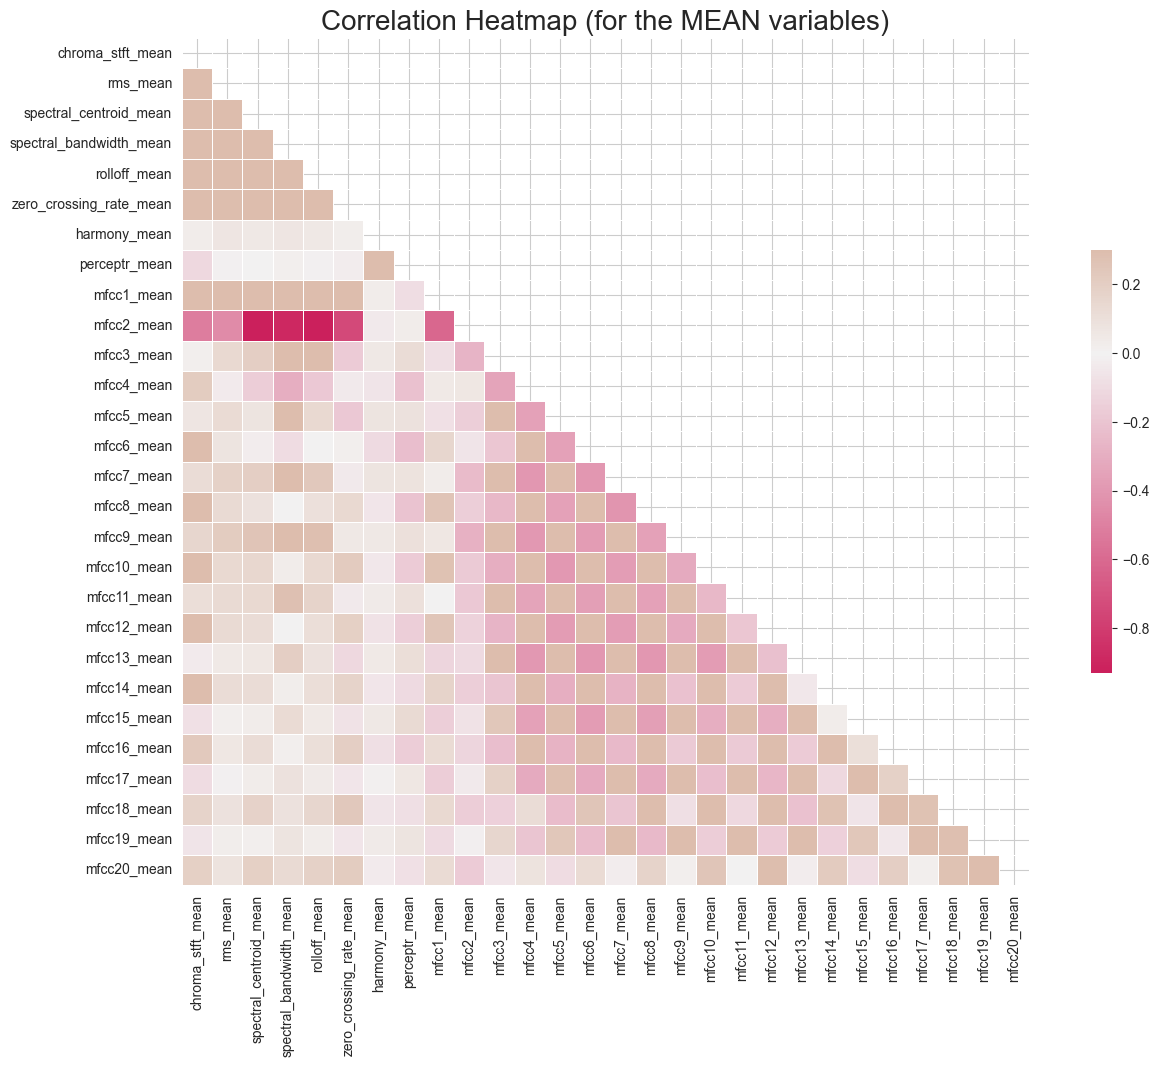

In [192]:
# Calculate the Correlation Matrix for 'mean' variables
mean_columns = [col for col in df.columns if 'mean' in col]
correlation_matrix = df[mean_columns].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=np.bool))

# Create a matplotlib figure
fig, ax = plt.subplots(figsize=(16, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s=90, l=45, n=5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=0.3, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig("Corr_Heatmap.png")


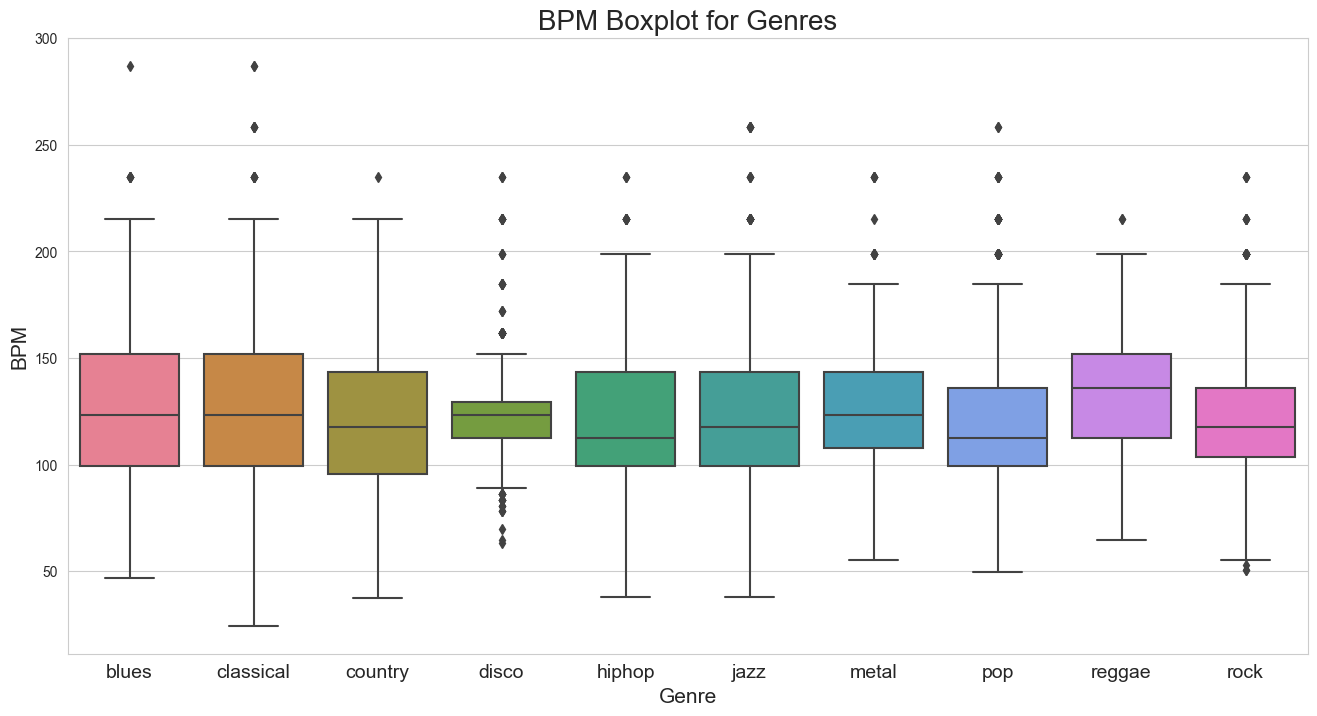

In [193]:
x = df[["label", "tempo"]]

fig, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM_Boxplot.png")

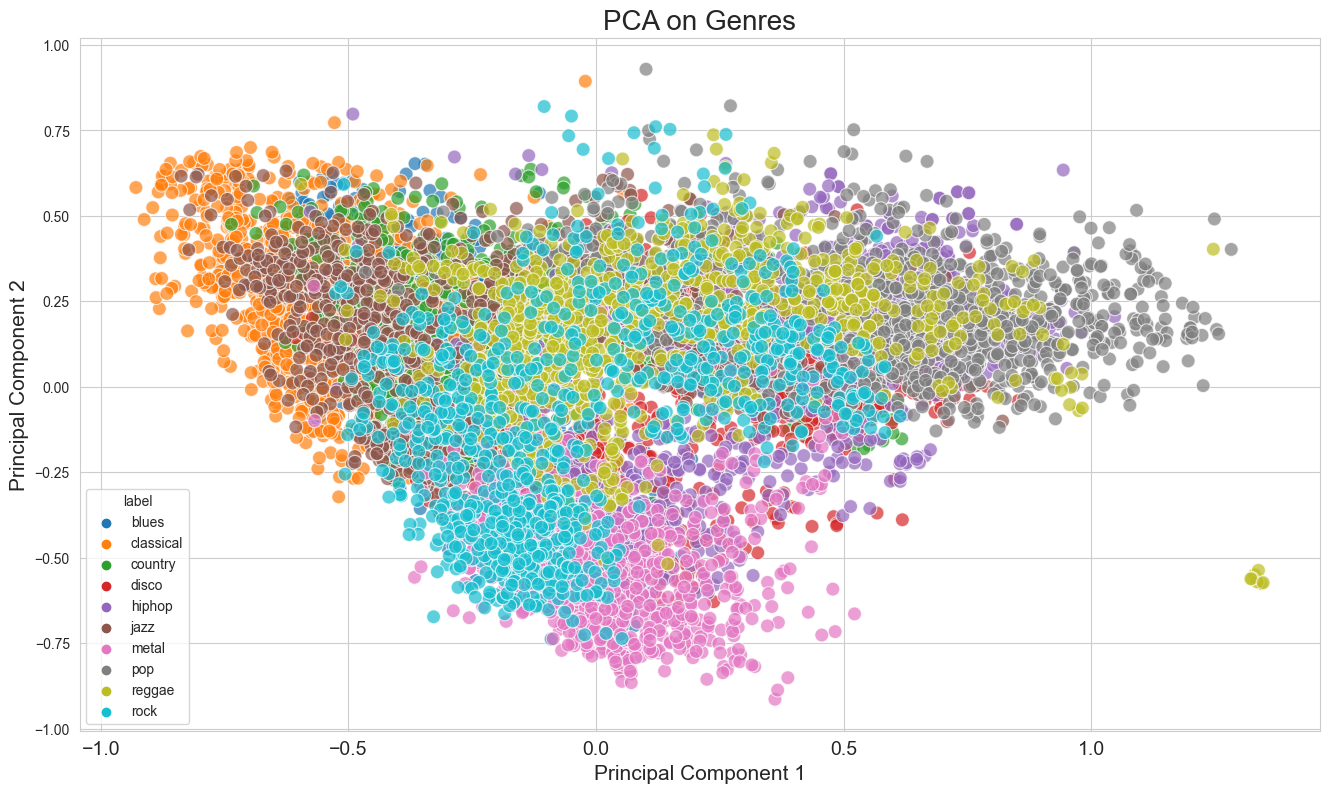

In [194]:
# Prepare data for PCA
data = df.iloc[:, 1:]
y = data['label']
X = data.drop('label', axis=1)

# Normalize the data
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns=cols)

# Perform PCA with 2 components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)
principal_df = pd.DataFrame(data=principal_components, columns=['pc1', 'pc2'])

# Concatenate with the target label
final_df = pd.concat([principal_df, y], axis=1)

# Create a scatterplot for PCA
plt.figure(figsize=(16, 9))
sns.scatterplot(x="pc1", y="pc2", data=final_df, hue="label", alpha=0.7, s=100)

plt.title('PCA on Genres', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=10)
plt.xlabel("Principal Component 1", fontsize=15)
plt.ylabel("Principal Component 2", fontsize=15)
plt.savefig("PCA_Scatterplot.png")

# DATA PREPARATION

In [195]:
#Missing Value Management
print("Columns with NA values: ",list(df.columns[df.isnull().any()]))

Columns with NA values:  []


In [196]:
# map labels to index & update labels in df to index
label_index = {label: i for i, label in enumerate(df['label'].unique())}
index_label = {i: label for label, i in label_index.items()}

df['label'] = df['label'].map(label_index)


# Shuffling Data, Splitting into Train, Valid/Dev & Test Sets

In [197]:
# Shuffle samples
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)

# Remove irrelevant columns
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)

# Separate features and labels
df_y = df_shuffle.pop('label')
df_X = df_shuffle

In [198]:
# Convert Pandas DataFrames to NumPy arrays
X_train = df_X.to_numpy()
y_train = df_y.to_numpy()

In [199]:
# Split into train, dev, and test sets
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, train_size=0.7, random_state=seed, stratify=y_train)

# Model Training